# Mentions

## Data prep

### Load the data and count.

In [1]:
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import tweet_load_iter, tweet_type

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Simply the tweet on load
def mention_transform(tweet):
    mentions = []
    if 'retweeted_status' not in tweet and 'quoted_status' not in tweet:
        for mention in tweet.get('entities', {}).get('user_mentions', []):
            mentions.append({
                'tweet_id': tweet['id_str'],
                'user_id': tweet['user']['id_str'],
                'screen_name': tweet['user']['screen_name'],
                'mention_user_id': mention['id_str'],
                'mention_screen_name': mention['screen_name'],
                'tweet_created_at': date_parse(tweet['created_at'])
            })
    return mentions

mention_df = pd.DataFrame(tweet_load_iter(tweet_transform_func=mention_transform))


INFO:root:Loading from tweets/6eea2088e010437da4b6031c2abffdc9_001.json.gz
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
INFO:root:Loading from tweets/a7bcdbde7a104285b92fe26e286f2543_001.json.gz
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000
DEBUG:root:Loaded 500000
DEBUG:root:Loaded 550000
DEBUG:root:Loaded 600000
INFO:root:Loading from tweets/e1c824ff2b3c4c5a9a93a16e5036d09a_001.json.gz
DEBUG:root:Loaded 650000
DEBUG:root:Loaded 700000
DEBUG:root:Loaded 750000


### Number of mentions found in the dataset

In [2]:
mention_df[['mention_user_id']].count()

mention_user_id    277457
dtype: int64

### The mention data
Each mention consists of the tweet id, the screen name and user id that is mentioned,
and the screen_name and user_id that is mentioning.

In [3]:
mention_df.head()

,mention_screen_name,mention_user_id,screen_name,tweet_created_at,tweet_id,user_id
0,nielslesniewski,140286364,loren_duggan,2017-03-30 12:41:33+00:00,847428582821449730,780221130
1,BrianToddCNN,104851609,akesslerdc,2017-03-29 14:02:14+00:00,847086500944777220,285772181
2,JamesVGrimaldi,17178161,akesslerdc,2017-03-25 02:45:16+00:00,845466584625885184,285772181
3,realDonaldTrump,25073877,akesslerdc,2017-03-24 20:51:43+00:00,845377611165552640,285772181
4,POTUS,822215679726100480,akesslerdc,2017-03-24 20:46:38+00:00,845376332011913217,285772181


### Remove duplicates

In [4]:
dedupe_mention_df = mention_df.drop_duplicates()
dedupe_mention_df[['mention_user_id']].count()

mention_user_id    274825
dtype: int64

### Create lookup of mentioned user ids to screen names

In [5]:
# From the mentions, extract map of user ids to screen names
mention_user_id_lookup_df = mention_df.loc[mention_df.groupby('mention_user_id')['tweet_created_at'].idxmax()].ix[:,['mention_user_id', 'mention_screen_name']].set_index(['mention_user_id'])
mention_user_id_lookup_df.count()

mention_screen_name    45206
dtype: int64

In [6]:
mention_user_id_lookup_df.head()

,mention_screen_name
mention_user_id,
100002112,whyyradiotimes
100005598,hotelkeys
10000772,JMoLawre
1000228238,adwooldridge
100025240,itsbull


### Create lookup of user ids to screen names

In [7]:
# From the users (not the mentions), extract map of user ids to screen names
user_id_lookup_df = mention_df.loc[mention_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    1817
dtype: int64

### Group mentions by mentioned user id

In [8]:
# Group by user_id
# This count should match the user_id map count
mention_summary_user_id_df = pd.DataFrame(dedupe_mention_df.groupby('mention_user_id').size(), columns=['mention_count'])
mention_summary_user_id_df.count()

mention_count    45206
dtype: int64

In [9]:
mention_summary_user_id_df.head()

,mention_count
mention_user_id,
100002112,1
100005598,5
10000772,1
1000228238,2
100025240,1


### Add back in the mention screen names

In [10]:
# Join with user id map
mention_summary_screen_name_df = mention_summary_user_id_df.join(mention_user_id_lookup_df)
mention_summary_screen_name_df.count()

mention_count          45206
mention_screen_name    45206
dtype: int64

In [11]:
mention_summary_screen_name_df.head()

,mention_count,mention_screen_name
mention_user_id,,
100002112,1,whyyradiotimes
100005598,5,hotelkeys
10000772,1,JMoLawre
1000228238,2,adwooldridge
100025240,1,itsbull


### Add users types for mentions

In [12]:
# Load lookups of known users
from utils import load_user_type_lookup_df

user_type_lookup_df = load_user_type_lookup_df()[['type']]
user_type_lookup_df.count()

type    12755
dtype: int64

In [13]:
user_type_lookup_df.head()

,type
user_id,
2345626885,journalists
780221130,journalists
285772181,journalists
29607664,journalists
9484732,journalists


In [14]:
user_type_lookup_df['type'].value_counts()

media                4525
journalists          3360
government           3046
politicians           789
ngo                   222
pundit                169
other                 138
other_political       136
business              117
cultural              115
academic              114
foreign_political      24
Name: type, dtype: int64

In [15]:
# Join the mentions and the known users
mention_summary_type_df = mention_summary_screen_name_df.join(user_type_lookup_df, how='left')
mention_summary_type_df['type'].fillna('unknown', inplace=True)
mention_summary_type_df.index.name = 'user_id'
mention_summary_type_df.count()

mention_count          45206
mention_screen_name    45206
type                   45206
dtype: int64

In [16]:
mention_summary_type_df.head()

,mention_count,mention_screen_name,type
user_id,,,
100002112,1,whyyradiotimes,unknown
100005598,5,hotelkeys,unknown
10000772,1,JMoLawre,unknown
1000228238,2,adwooldridge,unknown
100025240,1,itsbull,unknown


### Add number of users mentioning
Which is different than the number of mentions.

In [17]:
mention_user_id_per_user_df = dedupe_mention_df[['mention_user_id', 'user_id']].drop_duplicates()
mention_user_id_per_user_summary_df = pd.DataFrame(mention_user_id_per_user_df.groupby('mention_user_id').size(), columns=['users_mentioning_count'])
mention_user_id_per_user_summary_df.index.name = 'user_id'
mention_user_id_per_user_summary_df.head()
# Join with mention_summary_type_df
mention_summary_df = mention_summary_type_df.join(mention_user_id_per_user_summary_df)
mention_summary_df['percent_of_users_mentioning'] = mention_summary_df.users_mentioning_count / user_id_lookup_df['screen_name'].count()
mention_summary_df.head()


,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
100002112,1,whyyradiotimes,unknown,1,0.000550
100005598,5,hotelkeys,unknown,3,0.001651
10000772,1,JMoLawre,unknown,1,0.000550
1000228238,2,adwooldridge,unknown,1,0.000550
100025240,1,itsbull,unknown,1,0.000550


## Mention summary

### Mentions per user
For users that made any mentions. Also to possible to figure this out for all users.

In [18]:
dedupe_mention_df['user_id'].value_counts().describe()

count     1817.000000
mean       151.252064
std        445.439562
min          1.000000
25%         14.000000
50%         48.000000
75%        155.000000
max      14997.000000
Name: user_id, dtype: float64

### How long is the tail?

In [19]:
mention_grouped_by_users_mentioning_df = mention_summary_df[['mention_count', 'users_mentioning_count']].groupby(by='users_mentioning_count').agg([np.sum, np.size])
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] = mention_grouped_by_users_mentioning_df['mention_count', 'sum'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mention_count_sum'] / mention_grouped_by_users_mentioning_df['mention_count', 'sum'].sum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] = mention_grouped_by_users_mentioning_df['mention_count', 'size'].cumsum()
mention_grouped_by_users_mentioning_df['cumulative_mentioned_users_percentage'] = mention_grouped_by_users_mentioning_df['cumulative_mentioned_users'] / mention_grouped_by_users_mentioning_df['mention_count', 'size'].sum()
mention_grouped_by_users_mentioning_df

mention_count        cumulative_mention_count_sum  \
                                 sum   size                                
users_mentioning_count                                                     
1                              60462  32893                        60462   
2                              20442   5159                        80904   
3                              12517   2042                        93421   
4                              10494   1106                       103915   
5                               8404    718                       112319   
6                               6391    486                       118710   
7                               6336    385                       125046   
8                               5282    277                       130328   
9                               6017    262                       136345   
10                              4873    225                       141218   
11                              4632    168                       145850   
12                              3655    129                       149505   
13                              3325    108                       152830   
14                              2859     88                       155689   
15                              3322     93                       159011   
16                              2683     67                       161694   
17                              2993     78                       164687   
18                              2544     67                       167231   
19                              3506     74                       170737   
20                              2614     51                       173351   
21                              3274     51                       176625   
22                              2532     49                       179157   
23                              2648     41                       181805   
24                              3224     41                       185029   
25                              1981     30                       187010   
26                              1867     30                       188877   
27                              1536     22                       190413   
28                              1539     24                       191952   
29                              1914     30                       193866   
30                              2267     26                       196133   
...                              ...    ...                          ...   
93                               195      1                       244820   
94                               531      2                       245351   
95                               201      1                       245552   
97                               442      2                       245994   
98                               305      1                       246299   
99                               781      1                       247080   
103                              888      3                       247968   
107                              582      2                       248550   
116                              426      1                       248976   
117                              640      2                       249616   
119                              616      1                       250232   
124                              616      2                       250848   
130                              758      2                       251606   
131                              710      1                       252316   
132                              702      1                       253018   
134                              394      1                       253412   
135                              797      1                       254209   
138                             1515      1                       255724   
168                             2435      1                       25815

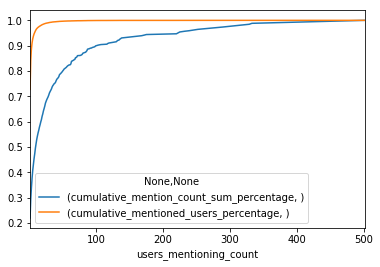

In [20]:
%matplotlib inline
mention_grouped_by_users_mentioning_df[['cumulative_mention_count_sum_percentage', 'cumulative_mentioned_users_percentage']].plot()

## Cut off the tail.
Removes users that were only mentioned by 1 user.

In [21]:
mention_summary_df.drop(mention_summary_df[mention_summary_df.users_mentioning_count == 1].index, inplace=True)
mention_summary_df['mention_screen_name'].count()

12313

## Approach 1: By mention count

### Top accounts (by mention count)
Unknown for type indicates that it is not matched with an known Twitter account.

In [22]:
mention_summary_df.sort_values('mention_count', ascending=False).head(50)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
25073877,3229,realDonaldTrump,politicians,502,0.276280
822215679726100480,3028,POTUS,politicians,329,0.181068
818927131883356161,2507,PressSec,politicians,289,0.159053
51241574,2435,AP,media,168,0.092460
3108351,1963,WSJ,media,225,0.123830
15754281,1515,USATODAY,media,138,0.075949
18916432,1474,SpeakerRyan,politicians,252,0.138690
459277523,1218,BloombergBNA,media,63,0.034673
18956073,1065,dcexaminer,media,69,0.037975


### Account types (by mention count)

In [23]:
types_by_mention_count_df = mention_summary_df[['type', 'mention_count']].groupby('type').sum()
types_by_mention_count_df['type_percentage']= types_by_mention_count_df['mention_count'] / types_by_mention_count_df['mention_count'].sum()
types_by_mention_count_df.sort_values('mention_count', ascending=False)

,mention_count,type_percentage
type,,
journalists,75526,0.352328
unknown,43608,0.203431
media,38374,0.179014
politicians,29976,0.139838
government,5768,0.026908
pundit,4465,0.020829
other_political,3891,0.018151
ngo,3515,0.016397
academic,2570,0.011989


## Approach 2: Per user
Mentions by type per user.
TODO: Drop tail from this.

### Add type by merging screen name lookup

In [24]:
mention_all_join_df = pd.merge(dedupe_mention_df, user_type_lookup_df[['type']], how='left', left_on='mention_user_id', right_index=True)
mention_all_join_df['type'].fillna('unknown', inplace=True)
# Drop tail
mention_all_join_limited_df = mention_all_join_df[mention_all_join_df.mention_user_id.isin(mention_summary_df.index)]
mention_all_join_limited_df.head()

,mention_screen_name,mention_user_id,screen_name,tweet_created_at,tweet_id,user_id,type
0,nielslesniewski,140286364,loren_duggan,2017-03-30 12:41:33+00:00,847428582821449730,780221130,journalists
2,JamesVGrimaldi,17178161,akesslerdc,2017-03-25 02:45:16+00:00,845466584625885184,285772181,journalists
3,realDonaldTrump,25073877,akesslerdc,2017-03-24 20:51:43+00:00,845377611165552640,285772181,politicians
4,POTUS,822215679726100480,akesslerdc,2017-03-24 20:46:38+00:00,845376332011913217,285772181,politicians
5,mattfleg,218276360,adamliptak,2017-03-31 16:11:20+00:00,847843766601953280,29607664,journalists


In [25]:
mention_summary_by_user_df = mention_all_join_limited_df.groupby([mention_all_join_limited_df.user_id, mention_all_join_limited_df.type]).size().unstack().fillna(0)
# Add a total column
mention_summary_by_user_df['total'] = mention_summary_by_user_df.sum(axis=1)
for col_name in mention_summary_by_user_df.columns[:-1]:
    mention_summary_by_user_df['{}_percent'.format(col_name)] = mention_summary_by_user_df[col_name] / mention_summary_by_user_df.total
mention_summary_by_user_df.head(10)

type,academic,business,cultural,foreign_political,government,journalists,media,ngo,other,other_political,...,foreign_political_percent,government_percent,journalists_percent,media_percent,ngo_percent,other_percent,other_political_percent,politicians_percent,pundit_percent,unknown_percent
user_id,,,,,,,,,,,,,,,,,,,,,
100165378,1.0,2.0,14.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,...,0.000000,0.000000,0.061224,0.040816,0.000000,0.000000,0.020408,0.204082,0.000000,0.326531
1001991865,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
1002229862,0.0,0.0,1.0,0.0,7.0,19.0,4.0,1.0,0.0,0.0,...,0.000000,0.155556,0.422222,0.088889,0.022222,0.000000,0.000000,0.066667,0.000000,0.222222
100802089,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,...,0.000000,0.000000,0.357143,0.214286,0.000000,0.000000,0.000000,0.285714,0.000000,0.142857
100860790,0.0,0.0,0.0,0.0,0.0,50.0,15.0,4.0,0.0,1.0,...,0.000000,0.000000,0.476190,0.142857,0.038095,0.000000,0.009524,0.038095,0.000000,0.295238
1009749229,2.0,0.0,0.0,0.0,3.0,57.0,46.0,33.0,0.0,0.0,...,0.000000,0.017045,0.323864,0.261364,0.187500,0.000000,0.000000,0.000000,0.011364,0.187500
1013785220,0.0,0.0,0.0,1.0,1.0,22.0,20.0,0.0,0.0,0.0,...,0.015873,0.015873,0.349206,0.317460,0.000000,0.000000,0.000000,0.126984,0.000000,0.174603
102171691,1.0,0.0,4.0,0.0,3.0,91.0,502.0,3.0,1.0,0.0,...,0.000000,0.004518,0.137048,0.756024,0.004518,0.001506,0.000000,0.061747,0.001506,0.025602
102238997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.000000,0.000000,0.125000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.625000


### Average of percent of mentions by type for each user
That is, for each user determine the percent of mentions by type. Then take the average of each type.

Thus, this mention analysis is on a per-user basis, accounting for how prolific a tweeter a user is. (That is, users who tweet aren't weighed more heavily.)


In [26]:
mention_summary_by_user_df.filter(axis=1, regex="_percent$").mean()

type
academic_percent             0.008560
business_percent             0.019375
cultural_percent             0.010492
foreign_political_percent    0.001594
government_percent           0.032609
journalists_percent          0.292456
media_percent                0.240539
ngo_percent                  0.016408
other_percent                0.002673
other_political_percent      0.010455
politicians_percent          0.121034
pundit_percent               0.007983
unknown_percent              0.235822
dtype: float64

## Approach 3: By count of users mentioning
The number of users that mentioned an account. Thus, each user counts as 1, even if that user made multiple mentions of the account.

This weights an account that is mentioned by a 100 users more heavily than an account that is mentioned a 100 times by a single user.

In [27]:
mention_summary_df.sort_values('users_mentioning_count', ascending=False).head(20)

,mention_count,mention_screen_name,type,users_mentioning_count,percent_of_users_mentioning
user_id,,,,,
25073877,3229,realDonaldTrump,politicians,502,0.276280
807095,1022,nytimes,media,333,0.183269
822215679726100480,3028,POTUS,politicians,329,0.181068
818927131883356161,2507,PressSec,politicians,289,0.159053
18916432,1474,SpeakerRyan,politicians,252,0.138690
2467791,601,washingtonpost,media,239,0.131535
759251,760,CNN,media,232,0.127683
3108351,1963,WSJ,media,225,0.123830
9300262,811,politico,media,220,0.121079


### Account types (by count of users mentioning)

In [28]:
types_by_users_mentioning_df = mention_summary_df[['type', 'users_mentioning_count']].groupby('type').sum()
types_by_users_mentioning_df['type_percentage']= types_by_users_mentioning_df['users_mentioning_count'] / types_by_users_mentioning_df['users_mentioning_count'].sum()
types_by_users_mentioning_df.sort_values('users_mentioning_count', ascending=False)

,users_mentioning_count,type_percentage
type,,
journalists,29671,0.363428
unknown,23353,0.286041
politicians,10108,0.123809
media,8578,0.105068
government,2201,0.026959
other_political,1643,0.020124
ngo,1624,0.019892
pundit,1168,0.014306
business,1136,0.013914


## Unknown accounts
Remember, the tail has been cut off

### Number of unknown accounts

In [29]:
 mention_summary_df[mention_summary_df.type == 'unknown'].count()

mention_count                  7805
mention_screen_name            7805
type                           7805
users_mentioning_count         7805
percent_of_users_mentioning    7805
dtype: int64

### Number of known accounts

In [30]:
 mention_summary_df[mention_summary_df.type != 'unknown'].count()

mention_count                  4508
mention_screen_name            4508
type                           4508
users_mentioning_count         4508
percent_of_users_mentioning    4508
dtype: int64

### Top unknown by mention count that are mentioned by at least 5 users

In [31]:
top_not_known_mention_df = mention_summary_df[(mention_summary_df.type == 'unknown') & (mention_summary_df.users_mentioning_count >= 5)].sort_values('mention_count', ascending=False)[['mention_screen_name', 'mention_count', 'users_mentioning_count']]
top_not_known_mention_df.head(50)

,mention_screen_name,mention_count,users_mentioning_count
user_id,,,
312800783,AmericaNewsroom,104,13
490013684,KFoleyFL,62,5
437737633,jbillinson,61,7
293314112,DavidWright_CNN,58,27
1976143068,EmmanuelMacron,57,15
14304618,AmandaWills,57,12
20748745,BradThor,56,6
20975060,johnrobertsFox,55,23
15673703,karenhandel,54,22


### Write top accounts to file

In [32]:
top_not_known_mention_df.to_csv('unknown_mentions.csv')